In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_json("dev.json")

In [3]:
data_test = pd.DataFrame()
context = []
questions = []
answers = []
for row in data["data"]:
    for i in range(len(row["paragraphs"][0]["qas"])):
        context.append(row["paragraphs"][0]["context"])
        questions.append(row["paragraphs"][0]["qas"][i]["question"])
        answers.append(row["paragraphs"][0]["qas"][i]["answers"][0]["text"])
data_test["context"] = context
data_test["question"] = questions
data_test["answer"] = answers

In [4]:
from pytorch_pretrained_bert.tokenization import (BasicTokenizer,
                                                  BertTokenizer, whitespace_tokenize)
import collections
import torch
from torch.utils.data import TensorDataset
from pytorch_pretrained_bert.modeling import BertForQuestionAnswering, BertConfig
import math
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
class SquadExample(object):
    """
    A single training/test example for the Squad dataset.
    For examples without an answer, the start and end position are -1.
    """

    def __init__(self,
                 example_id,
                 para_text,
                 qas_id,
                 question_text,
                 doc_tokens,
                 unique_id):
        self.qas_id = qas_id
        self.question_text = question_text
        self.doc_tokens = doc_tokens
        self.example_id = example_id
        self.para_text = para_text
        self.unique_id = unique_id

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        s = ""
        s += "qas_id: %s" % (self.qas_id)
        s += ", question_text: %s" % (
            self.question_text)
        s += ", doc_tokens: [%s]" % (" ".join(self.doc_tokens))

        return s


### Convert paragraph to tokens and returns question_text
def read_squad_examples(input_data):
    """Read a SQuAD json file into a list of SquadExample."""

    def is_whitespace(c):
        if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
            return True
        return False

    i = 0
    examples = []
    for entry in input_data:
        example_id = entry['id']
        paragraph_text = entry['text']
        doc_tokens = []
        prev_is_whitespace = True
        for c in paragraph_text:
            if is_whitespace(c):
                prev_is_whitespace = True
            else:
                if prev_is_whitespace:
                    doc_tokens.append(c)
                else:
                    doc_tokens[-1] += c
                prev_is_whitespace = False

        for qa in entry['ques']:
            qas_id = i
            question_text = qa

            example = SquadExample(example_id=example_id,
                                   qas_id=qas_id,
                                   para_text=paragraph_text,
                                   question_text=question_text,
                                   doc_tokens=doc_tokens,
                                   unique_id=i)
            i += 1
            examples.append(example)

    return examples


def _check_is_max_context(doc_spans, cur_span_index, position):
    """Check if this is the 'max context' doc span for the token."""
    best_score = None
    best_span_index = None
    for (span_index, doc_span) in enumerate(doc_spans):
        end = doc_span.start + doc_span.length - 1
        if position < doc_span.start:
            continue
        if position > end:
            continue
        num_left_context = position - doc_span.start
        num_right_context = end - position
        score = min(num_left_context, num_right_context) + 0.01 * doc_span.length
        if best_score is None or score > best_score:
            best_score = score
            best_span_index = span_index

    return cur_span_index == best_span_index


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self,
                 unique_id,
                 example_index,
                 doc_span_index,
                 tokens,
                 token_is_max_context,
                 token_to_orig_map,
                 input_ids,
                 input_mask,
                 segment_ids):
        self.doc_span_index = doc_span_index
        self.unique_id = unique_id
        self.example_index = example_index
        self.tokens = tokens
        self.token_is_max_context = token_is_max_context
        self.token_to_orig_map = token_to_orig_map
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids


def convert_examples_to_features(examples, tokenizer, max_seq_length,
                                 doc_stride, max_query_length):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
    unique_id = 1
    for (example_index, example) in enumerate(examples):
        query_tokens = tokenizer.tokenize(example.question_text)
        ### Truncate the query if query length > max_query_length..
        if len(query_tokens) > max_query_length:
            query_tokens = query_tokens[0:max_query_length]

        tok_to_orig_index = []
        orig_to_tok_index = []
        all_doc_tokens = []
        for (i, token) in enumerate(example.doc_tokens):
            orig_to_tok_index.append(len(all_doc_tokens))
            sub_tokens = tokenizer.tokenize(token)
            for sub_token in sub_tokens:
                tok_to_orig_index.append(i)
                all_doc_tokens.append(sub_token)

        tok_start_position = None
        tok_end_position = None

        max_tokens_for_doc = max_seq_length - len(query_tokens) - 3

        # We can have documents that are longer than the maximum sequence length.
        # To deal with this we do a sliding window approach, where we take chunks
        # of the up to our max length with a stride of `doc_stride`.
        _DocSpan = collections.namedtuple(  # pylint: disable=invalid-name
            "DocSpan", ["start", "length"])
        doc_spans = []
        start_offset = 0
        while start_offset < len(all_doc_tokens):
            length = len(all_doc_tokens) - start_offset
            if length > max_tokens_for_doc:
                length = max_tokens_for_doc
            doc_spans.append(_DocSpan(start=start_offset, length=length))
            if start_offset + length == len(all_doc_tokens):
                break
            start_offset += min(length, doc_stride)

        for (doc_span_index, doc_span) in enumerate(doc_spans):
            tokens = []
            token_to_orig_map = {}
            token_is_max_context = {}
            segment_ids = []
            tokens.append("[CLS]")
            segment_ids.append(0)
            for token in query_tokens:
                tokens.append(token)
                segment_ids.append(0)
            tokens.append("[SEP]")
            segment_ids.append(0)

            for i in range(doc_span.length):
                split_token_index = doc_span.start + i
                token_to_orig_map[len(tokens)] = tok_to_orig_index[split_token_index]

                is_max_context = _check_is_max_context(doc_spans, doc_span_index,
                                                       split_token_index)
                token_is_max_context[len(tokens)] = is_max_context
                tokens.append(all_doc_tokens[split_token_index])
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            while len(input_ids) < max_seq_length:
                input_ids.append(0)
                input_mask.append(0)
                segment_ids.append(0)

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            features.append(InputFeatures(unique_id=unique_id,
                                          example_index=example_index,
                                          doc_span_index=doc_span_index,
                                          tokens=tokens,
                                          token_is_max_context=token_is_max_context,
                                          token_to_orig_map=token_to_orig_map,
                                          input_ids=input_ids,
                                          input_mask=input_mask,
                                          segment_ids=segment_ids))
            unique_id += 1

    return features


def _get_best_indexes(logits, n_best_size):
    """Get the n-best logits from a list."""
    index_and_score = sorted(enumerate(logits), key=lambda x: x[1], reverse=True)
    best_indexes = []
    for i in range(len(index_and_score)):
        if i >= n_best_size:
            break
        best_indexes.append(index_and_score[i][0])

    return best_indexes


def get_final_text(pred_text, orig_text, do_lower_case, verbose_logging=False):
    """Project the tokenized prediction back to the original text."""

    def _strip_spaces(text):
        ns_chars = []
        ns_to_s_map = collections.OrderedDict()
        for (i, c) in enumerate(text):
            if c == " ":
                continue
            ns_to_s_map[len(ns_chars)] = i
            ns_chars.append(c)
        ns_text = "".join(ns_chars)
        return (ns_text, ns_to_s_map)

    tokenizer = BasicTokenizer(do_lower_case=do_lower_case)

    tok_text = " ".join(tokenizer.tokenize(orig_text))

    start_position = tok_text.find(pred_text)
    if start_position == -1:
        if verbose_logging:
            logger.info(
                "Unable to find text: '%s' in '%s'" % (pred_text, orig_text))
        return orig_text
    end_position = start_position + len(pred_text) - 1

    (orig_ns_text, orig_ns_to_s_map) = _strip_spaces(orig_text)
    (tok_ns_text, tok_ns_to_s_map) = _strip_spaces(tok_text)

    if len(orig_ns_text) != len(tok_ns_text):
        if verbose_logging:
            logger.info("Length not equal after stripping spaces: '%s' vs '%s'",
                        orig_ns_text, tok_ns_text)
        return orig_text

    # We then project the characters in `pred_text` back to `orig_text` using
    # the character-to-character alignment.
    tok_s_to_ns_map = {}
    for (i, tok_index) in tok_ns_to_s_map.items():
        tok_s_to_ns_map[tok_index] = i

    orig_start_position = None
    if start_position in tok_s_to_ns_map:
        ns_start_position = tok_s_to_ns_map[start_position]
        if ns_start_position in orig_ns_to_s_map:
            orig_start_position = orig_ns_to_s_map[ns_start_position]

    if orig_start_position is None:
        if verbose_logging:
            logger.info("Couldn't map start position")
        return orig_text

    orig_end_position = None
    if end_position in tok_s_to_ns_map:
        ns_end_position = tok_s_to_ns_map[end_position]
        if ns_end_position in orig_ns_to_s_map:
            orig_end_position = orig_ns_to_s_map[ns_end_position]

    if orig_end_position is None:
        if verbose_logging:
            logger.info("Couldn't map end position")
        return orig_text

    output_text = orig_text[orig_start_position:(orig_end_position + 1)]
    return output_text


_PrelimPrediction = collections.namedtuple(  # pylint: disable=invalid-name
    "PrelimPrediction",
    ["feature_index", "start_index", "end_index", "start_logit", "end_logit"])


def _compute_softmax(scores):
    """Compute softmax probability over raw logits."""
    if not scores:
        return []

    max_score = None
    for score in scores:
        if max_score is None or score > max_score:
            max_score = score

    exp_scores = []
    total_sum = 0.0
    for score in scores:
        x = math.exp(score - max_score)
        exp_scores.append(x)
        total_sum += x

    probs = []
    for score in exp_scores:
        probs.append(score / total_sum)
    return probs


_NbestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
    "NbestPrediction", ["text", "start_logit", "end_logit"])


def predict(examples, all_features, all_results, max_answer_length):
    n_best_size = 10

    ### Adding index to feature ###
    example_index_to_features = collections.defaultdict(list)
    for feature in all_features:
        example_index_to_features[feature.example_index].append(feature)

    unique_id_to_result = {}
    for result in all_results:
        unique_id_to_result[result.unique_id] = result

    all_predictions = collections.OrderedDict()

    for example in examples:
        index = 0
        features = example_index_to_features[example.unique_id]
        prelim_predictions = []

        for (feature_index, feature) in enumerate(features):
            result = unique_id_to_result[feature.unique_id]
            start_indexes = _get_best_indexes(result.start_logits, n_best_size)
            end_indexes = _get_best_indexes(result.end_logits, n_best_size)
            for start_index in start_indexes:
                for end_index in end_indexes:
                    #### we remove the indexes which are invalid @
                    if start_index >= len(feature.tokens):
                        continue
                    if end_index >= len(feature.tokens):
                        continue
                    if start_index not in feature.token_to_orig_map:
                        continue
                    if end_index not in feature.token_to_orig_map:
                        continue
                    if not feature.token_is_max_context.get(start_index, False):
                        continue
                    if end_index < start_index:
                        continue
                    length = end_index - start_index + 1
                    if length > max_answer_length:
                        continue

                    prelim_predictions.append(
                        _PrelimPrediction(
                            feature_index=feature_index,
                            start_index=start_index,
                            end_index=end_index,
                            start_logit=result.start_logits[start_index],
                            end_logit=result.end_logits[end_index]))

        prelim_predictions = sorted(
            prelim_predictions,
            key=lambda x: (x.start_logit + x.end_logit),
            reverse=True)

        seen_predictions = {}
        nbest = []
        for pred in prelim_predictions:
            if len(nbest) >= n_best_size:
                break

            feature = features[pred.feature_index]
            if pred.start_index > 0:  # this is a non-null prediction
                tok_tokens = feature.tokens[pred.start_index:(pred.end_index + 1)]
                orig_doc_start = feature.token_to_orig_map[pred.start_index]
                orig_doc_end = feature.token_to_orig_map[pred.end_index]
                orig_tokens = example.doc_tokens[orig_doc_start:(orig_doc_end + 1)]
                tok_text = " ".join(tok_tokens)

                # De-tokenize WordPieces that have been split off.
                tok_text = tok_text.replace(" ##", "")
                tok_text = tok_text.replace("##", "")

                # Clean whitespace
                tok_text = tok_text.strip()
                tok_text = " ".join(tok_text.split())
                orig_text = " ".join(orig_tokens)

                final_text = get_final_text(tok_text, orig_text, True)
                if final_text in seen_predictions:
                    continue

                seen_predictions[final_text] = True
            else:
                final_text = ""
                seen_predictions[final_text] = True

            nbest.append(
                _NbestPrediction(
                    text=final_text,
                    start_logit=pred.start_logit,
                    end_logit=pred.end_logit))

        if not nbest:
            nbest.append(
                _NbestPrediction(text="empty", start_logit=0.0, end_logit=0.0))

        assert len(nbest) >= 1

        total_scores = []
        best_non_null_entry = None
        for entry in nbest:
            total_scores.append(entry.start_logit + entry.end_logit)
            if not best_non_null_entry:
                if entry.text:
                    best_non_null_entry = entry

        probs = _compute_softmax(total_scores)
        nbest_json = []
        for (i, entry) in enumerate(nbest):
            output = collections.OrderedDict()
            output["text"] = entry.text
            output["probability"] = probs[i]
            output["start_logit"] = entry.start_logit
            output["end_logit"] = entry.end_logit
            nbest_json.append(output)

        assert len(nbest_json) >= 1
        all_predictions[example] = (nbest_json[0]["text"], nbest_json[0]["probability"])
        index = +1
    return all_predictions


RawResult = collections.namedtuple("RawResult",
                                   ["unique_id", "start_logits", "end_logits"])


def predict_(context, question):
    device = torch.device("cuda")
    para = context
    para = para.strip("\n").replace("\r", " ").replace("\n", "")
    question = [question]
    for q in question:
        q = q.strip("\n")
    input_data = []
    paragraphs = {}
    paragraphs["id"] = 1
    paragraphs["text"] = para
    paragraphs["ques"] = [q]
    input_data.append(paragraphs)
    # print(input_data)
    ## input_data is a list of dictionary which has a paragraph and questions

    examples = read_squad_examples(input_data)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    eval_features = convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        max_seq_length=384,
        doc_stride=128,
        max_query_length=64)

    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)

    ### Loading Pretrained model for QnA
    config = BertConfig("Results/bert_config.json")
    model = BertForQuestionAnswering(config)
    model_path = "pytorch_model.bin"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    pred_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_example_index)
    # Run prediction for full data
    pred_sampler = SequentialSampler(pred_data)
    pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=9)

    predictions = []
    for input_ids, input_mask, segment_ids, example_indices in pred_dataloader:
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)

        with torch.no_grad():
            batch_start_logits, batch_end_logits = model(input_ids, segment_ids, input_mask)

        features = []
        example = []
        all_results = []

        for i, example_index in enumerate(example_indices):
            start_logits = batch_start_logits[i].detach().cpu().tolist()
            end_logits = batch_end_logits[i].detach().cpu().tolist()
            feature = eval_features[example_index.item()]
            unique_id = int(feature.unique_id)
            features.append(feature)
            all_results.append(RawResult(unique_id=unique_id,
                                         start_logits=start_logits,
                                         end_logits=end_logits))

        output = predict(examples, features, all_results, 30)
        predictions.append(output)

    ### For printing the results ####
    index = None
    for example in examples:
        if index != example.example_id:
            # print(example.para_text)
            index = example.example_id
            # print('\n')
            # print(colored('***********Question and Answers *************', 'red'))

        ques_text = example.question_text
        #print(ques_text)
        prediction, prob = predictions[math.floor(example.unique_id / 12)][example]
        return prediction, prob

In [68]:
predictions = []
confidence = []
for i in range(len(data_test)):
    output = predict_(data_test["context"].iloc[i], data_test["question"].iloc[i])
    predictions.append(output[0])
    confidence.append(output[1])
data_test["prediction"] = predictions
data_test["confidence"] = confidence


Which NFL team represented the AFC at Super Bowl 50?
Which NFL team represented the NFC at Super Bowl 50?
Where did Super Bowl 50 take place?
Which NFL team won Super Bowl 50?
What color was used to emphasize the 50th anniversary of the Super Bowl?
What was the theme of Super Bowl 50?
What day was the game played on?
What is the AFC short for?
What was the theme of Super Bowl 50?
What does AFC stand for?
What day was the Super Bowl played on?
Who won Super Bowl 50?
What venue did Super Bowl 50 take place in?
What city did Super Bowl 50 take place in?
If Roman numerals were used, what would Super Bowl 50 have been called?
Super Bowl 50 decided the NFL champion for what season?
What year did the Denver Broncos secure a Super Bowl title for the third time?
What city did Super Bowl 50 take place in?
What stadium did Super Bowl 50 take place in?
What was the final score of Super Bowl 50? 
What month, day and year did Super Bowl 50 take place? 
What year was Super Bowl 50?
What team was the 

How much of the European population did the black death kill?
When did the world's population finally recover from the black death?
For how long did the plague stick around?
An igneous rock is a rock that crystallizes from what?
Sedimentary rock can be turned into which of the three types of rock?
When the three types of rock are re-melted what is formed? 
What are the three major types of rock? 
What changes the mineral content of a rock?
How many miles south of Edinburgh is Newcastle?
How many miles from the north Sea is Newcastle?
What network is Newcastle a member of?
What county was Newcastle a part of until 1400?
What's the regional nickname for Newcastle and its surrounding area?
where is the Victoria and Albert Museum located?
how many permanent objects are located there?
when was the Victoria and Albert museum founded?
Who is the museum named for?
In which London borough is the Victoria and Albert Museum located?
In what year was the Victoria and Albert Museum founded?
Which m

Imperialism is responsible for the rapid spread of what?
What does UMC stand for?
What is the United Methodist Church?
When was the UMC founded?
Who founded the UMC?
What is the church's theological orientation?
When was the French and Indian War?
Who fought in the French and Indian war?
How many people were in French North American Colonies?
How many people were in British North American Colonies?
What concept did philosophers in antiquity use to study simple machines?
What was the belief that maintaining motion required force?
Who had mathmatical insite?
How long did it take to improve on Sir Isaac Newton's laws of motion?
Who develped the theory of relativity?


In [69]:
data_test.head()

,context,question,answer,prediction,confidence
0,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,Denver Broncos,Denver Broncos,0.959606
1,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,Carolina Panthers,0.839046
2,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"Santa Clara, California",Levi's Stadium,0.697287
3,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,Denver Broncos,Denver Broncos,0.736881
4,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,gold,gold,0.990147


In [71]:
data_test.to_csv("threshold.csv")

In [74]:
result = pd.read_csv("threshold.csv")

In [83]:
accCache = []
covcache = []
for conf in np.linspace(0,1,51):
    replied = result[result["confidence"] >= conf]
    accuracy = (replied["correct"] == 1).mean()
    covered = len(replied)/len(result)
    accCache.append(accuracy)
    covcache.append(covered)

In [5]:
questions = data_test["question"]
contexts = data_test["context"]
np.random.shuffle(questions)

In [6]:
data_test2 = pd.DataFrame()
data_test2["question"] = questions
data_test2["context"] = contexts
data_test2["answer"] = "unclassified"
data_test2 = data_test2.sample(frac = 0.2)

In [7]:
predictions = []
confidence = []
for i in tqdm(range(len(data_test2))):
    output = predict_(data_test2["context"].iloc[i], data_test2["question"].iloc[i])
    predictions.append(output[0])
    confidence.append(output[1])
data_test2["prediction"] = predictions
data_test2["confidence"] = confidence

100%|██████████| 65/65 [06:49<00:00,  6.31s/it] 


In [8]:
data_test2

,question,context,answer,prediction,confidence
11,How many sources of European Union law are there?,Super Bowl 50 was an American football game to...,unclassified,Super Bowl 50,0.355085
242,What size are adult Ctenophora?,Jacksonville is the largest city by population...,unclassified,"1,345,596",0.525694
197,What company was formed by the merger of Sky T...,The word pharmacy is derived from its root wor...,unclassified,The pharma,0.552699
27,When did the world's population finally recove...,Super Bowl 50 was an American football game to...,unclassified,"February 7, 2016",0.619028
254,"Are atmospheric oxygen levels going up, down, ...",A study by the World Institute for Development...,unclassified,the same as the bottom half of the population,0.207678


In [9]:
data_test2.to_csv("threhsold_unclassified.csv")

(array([ 5.,  5., 11.,  5.,  5.,  4.,  4.,  1.,  4.,  3.,  3.,  1.,  2.,
         3.,  1.,  1.,  0.,  1.,  0.,  6.]),
 array([0.1305679 , 0.1740395 , 0.21751111, 0.26098271, 0.30445432,
        0.34792592, 0.39139753, 0.43486913, 0.47834074, 0.52181234,
        0.56528395, 0.60875555, 0.65222716, 0.69569876, 0.73917037,
        0.78264197, 0.82611358, 0.86958518, 0.91305679, 0.95652839,
        1.        ]),
 <a list of 20 Patch objects>)

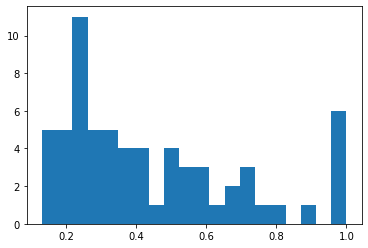

In [15]:
plt.hist(data_test2["confidence"], bins = 20)

In [18]:
data_test = pd.read_csv("threshold.csv")

(array([ 4.,  2.,  9., 17., 11., 19., 14., 22., 21., 11., 21., 16., 15.,
        15., 10.,  9., 14., 17., 29., 51.]),
 array([0.13036378, 0.1737828 , 0.21720182, 0.26062085, 0.30403987,
        0.34745889, 0.39087791, 0.43429693, 0.47771596, 0.52113498,
        0.564554  , 0.60797302, 0.65139204, 0.69481106, 0.73823009,
        0.78164911, 0.82506813, 0.86848715, 0.91190617, 0.9553252 ,
        0.99874422]),
 <a list of 20 Patch objects>)

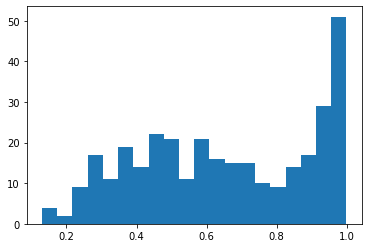

In [19]:
plt.hist(data_test["confidence"], bins = 20)

In [27]:
predCache = []
unclCache = []
for i in np.linspace(0,1,51):
    predCache.append(len(data_test[data_test["confidence"]>=i])/len(data_test))
    unclCache.append(len(data_test2[data_test2["confidence"]<i])/len(data_test2))

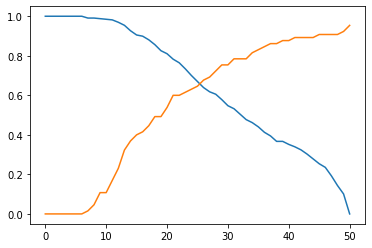

In [28]:
plt.plot(predCache)
plt.plot(unclCache)

In [31]:
print(len(data_test[data_test["confidence"]>=.4])/len(data_test))
print(len(data_test2[data_test2["confidence"]<.4])/len(data_test2))

0.7828746177370031
0.6


In [33]:
print(predCache, unclCache, np.linspace(0,1,51), sep = '\n')

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9908256880733946, 0.9877675840978594, 0.9847094801223242, 0.981651376146789, 0.9694189602446484, 0.9541284403669725, 0.926605504587156, 0.9051987767584098, 0.8990825688073395, 0.8807339449541285, 0.8562691131498471, 0.8256880733944955, 0.8103975535168195, 0.7828746177370031, 0.764525993883792, 0.7339449541284404, 0.7003058103975535, 0.6697247706422018, 0.6391437308868502, 0.617737003058104, 0.6055045871559633, 0.5779816513761468, 0.5474006116207951, 0.5321100917431193, 0.5045871559633027, 0.47706422018348627, 0.4617737003058104, 0.44036697247706424, 0.41284403669724773, 0.3944954128440367, 0.3669724770642202, 0.3669724770642202, 0.3516819571865443, 0.3394495412844037, 0.3241590214067278, 0.30275229357798167, 0.2782874617737003, 0.25382262996941896, 0.23547400611620795, 0.1926605504587156, 0.1437308868501529, 0.10091743119266056, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015384615384615385, 0.046153846153846156, 0.10769230769230